# Mi Águila - BI Test TelCo

### Desarrollada por: Juansebastian Gómez Muñoz
2 de agosto de 2021

## Problema

**EagleSouth** está preocupado por la retención de clientes. Necesitan comprender quién se va (clientes que cancelan su servicio con la compañía) y la empresa ha solicitado diseñar una estrategia para comprender el problema e implementar soluciones nuevas y rentables.

Resolver este problema se puede concentrar en responder las siguientes preguntas:

1. ¿Cuál es la probabilidad de que un cliente activo abandone una organización?
2. ¿Cuáles son los indicadores clave de la pérdida de clientes? 
3. ¿Qué estrategias de retención se pueden implementar en función de los resultados para disminuir la pérdida de clientes potenciales?

## Aproximación analítica

Predecir si un cliente decide cancelar o no el servicio con la compañía es una tarea de clasificación entre dos posibles valores: **Sí** o **No**. Por lo tanto el modelo desarrollado será de **clasificación**. Un modelo de este tipo va a permitir predecir el comportamiento de los clientes actuales respecto a su continuidad con los servicios de la compañía.

Los datos también contienen información **descriptiva** de los clientes en aspectos personales y otros asociados a los servicios contratados.

## Comprensión de datos (Data understanding)

EagleSouth nos ha proporcionado los datos. 

El primer archivo, `Train Set.csv`, incluye datos reales en los que los clientes han cancelado (*"churn"*) (dejado de usar su servicio) en el último mes. Este será el conjunto de datos para desarrollar el modelo y predecir la pérdida de clientes.

Este es un conjunto de datos de clientes históricos donde cada fila representa un cliente. Por lo general, *es menos costoso mantener clientes que adquirir nuevos*, por lo que el enfoque de este análisis es predecir los clientes con riesgo de cancelación de servicios y propuestas para que permanezcan en la empresa.

Este conjunto de datos proporciona información que ayudará a predecir qué tipo de servicio permitirá retener clientes.

El conjunto de datos incluye información sobre:

- Clientes que se fueron en el último mes: la columna se llama *Churn*
- Servicios a los que se ha suscrito cada cliente: teléfono, varias líneas, Internet, seguridad en línea, respaldo en línea, protección de dispositivos, soporte técnico y transmisión de TV y películas
- Información de la cuenta del cliente: cuánto tiempo ha sido cliente, contrato, método de pago, facturación electrónica, cargos mensuales y cargos totales
- Información demográfica sobre los clientes: sexo, rango de edad y si tienen pareja y/o dependientes.

Un segundo archivo, `Test sample No Label.xlsx`, contiene la misma información para un conjunto de usuarios actuales, y se le usará para predecir quién está en riesgo de cancelación.

Se importan las librerias básicas para iniciar el manejo de los datos.

In [1]:
import pandas as pd
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

### Carga de los datos desde un archivo CSV

Se utiliza el método de Pandas `read_csv()` para cargar los datos desde el archivo suministrado a un DataFrame llamado `churn_df` y visualizar la información que contiene.

Se usa el metodo `head()` para mostrar las primeras filas del dataframe. 

In [2]:
churn_df = pd.read_csv("Train Set.csv")
print(churn_df.head())

  customerID gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0     A00001   Male              0     Yes        Yes      66          Yes   
1     A00002   Male              0      No         No      29          Yes   
2     A00003   Male              0      No         No       9          Yes   
3     A00004   Male              1     Yes        Yes      26          Yes   
4     A00005   Male              0     Yes        Yes      55          Yes   

  MultipleLines InternetService       OnlineSecurity  ...  \
0           Yes             DSL                   No  ...   
1            No              No  No internet service  ...   
2            No     Fiber optic                   No  ...   
3           Yes     Fiber optic                   No  ...   
4            No              No  No internet service  ...   

      DeviceProtection          TechSupport          StreamingTV  \
0                  Yes                   No                  Yes   
1  No internet service  No i

## Preparación de datos (Data wrangling, formatting)

Es útil conocer los tipos de variables de los datos para decidir sobre el método de visualización a usar.

In [3]:
churn_df_info = churn_df.info()
print(churn_df_info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6143 entries, 0 to 6142
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        6143 non-null   object 
 1   gender            6143 non-null   object 
 2   SeniorCitizen     6143 non-null   int64  
 3   Partner           6143 non-null   object 
 4   Dependents        6143 non-null   object 
 5   tenure            6143 non-null   int64  
 6   PhoneService      6143 non-null   object 
 7   MultipleLines     6143 non-null   object 
 8   InternetService   6143 non-null   object 
 9   OnlineSecurity    6143 non-null   object 
 10  OnlineBackup      6143 non-null   object 
 11  DeviceProtection  6143 non-null   object 
 12  TechSupport       6143 non-null   object 
 13  StreamingTV       6143 non-null   object 
 14  StreamingMovies   6143 non-null   object 
 15  Contract          6143 non-null   object 
 16  PaperlessBilling  6143 non-null   object 


Algunas variables deben cambiarse de tipo para que sean de utilidad en el análisis. Se hace para dos de las varibles:
 -  "*SeniorCitizen*" puede ser usada como variable categorica tipo *object*
 -  "*TotalCharges*" es un valor y puede ser cambiado al tipo *float64*

In [4]:
churn_df['SeniorCitizen'] = churn_df['SeniorCitizen'].astype('object')
churn_df['TotalCharges'] = pd.to_numeric(churn_df['TotalCharges'],errors = 'coerce')
print(churn_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6143 entries, 0 to 6142
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        6143 non-null   object 
 1   gender            6143 non-null   object 
 2   SeniorCitizen     6143 non-null   object 
 3   Partner           6143 non-null   object 
 4   Dependents        6143 non-null   object 
 5   tenure            6143 non-null   int64  
 6   PhoneService      6143 non-null   object 
 7   MultipleLines     6143 non-null   object 
 8   InternetService   6143 non-null   object 
 9   OnlineSecurity    6143 non-null   object 
 10  OnlineBackup      6143 non-null   object 
 11  DeviceProtection  6143 non-null   object 
 12  TechSupport       6143 non-null   object 
 13  StreamingTV       6143 non-null   object 
 14  StreamingMovies   6143 non-null   object 
 15  Contract          6143 non-null   object 
 16  PaperlessBilling  6143 non-null   object 


Con base en la información anterior se sabe que cada columna tiene 6143 filas de datos y que en ninguna columna, excepto en *TotalCharges*,  se presentan datos faltantes. Para confirmar cuantos datos no se encuentran después de haber hecho el cambio de tipo de variable se buscan de la siguiente manera.

In [5]:
missing_data = churn_df.isnull()

print("TotalCharges")
print(missing_data["TotalCharges"].value_counts())

TotalCharges
False    6132
True       11
Name: TotalCharges, dtype: int64


En la columna *TotalCharges* hay once (11) valores faltantes. Estos se van a poblar con el valor promedio de la variable.

In [6]:
avg_totalCharges = churn_df["TotalCharges"].astype("float").mean(axis=0)
print("El promedio de la variable TotalCharges es:", avg_totalCharges)

El promedio de la variable TotalCharges es: 2272.941079582518


In [7]:
churn_df["TotalCharges"].replace(np.nan, avg_totalCharges, inplace=True)

Los datos suministrados tiene de variables, tanto categoricas como númericas, que contiene valores en diferentes rangos.

La información de los clientes es anonima. Las columnas dan la información respecto al perfil del cliente y sus productos con la compañía, así:

### Variables de entrada

1. customerID: identificación del cliente.
2. gender: Si el cliente es hombre o mujer. (Categorica: Male, Female).
3. SeniorCitizen: Si el cliente es una persona mayor o no. (binario: 1 (yes), 0(no)).
4. Partner: Si el cliente tiene un socio o no. (Categórica: Yes, No)
5. Dependents: Si el cliente tiene dependientes o no. (Categórica: Yes, No).
6. tenure: Número de meses que el cliente ha permanecido en la empresa. (Númerica)
7. PhoneService: Si el cliente tiene servicio telefónico o no. (Categórica: Yes, No).
8. MultipleLines: Si el cliente tiene varias líneas o no. (Categórica: Yes, No, No phone service)
9. InternetService: Proveedor de servicios de Internet del cliente. (Categórica: DSL, Fiber optic, No).
10. OnlineSecurity: Si el cliente tiene seguridad en línea o no. (Categórica: Yes, No, No internet service).
11. OnlineBackup: Si el cliente tiene una copia de seguridad en línea o no. (Categórica: Yes, No, No internet service).
12. DeviceProtection: Si el cliente tiene protección del dispositivo o no. (Categórica: Yes, No, No internet service).
13. TechSupport: Si el cliente tiene soporte técnico o no. (Categórica: Yes, No, No internet service).
14. StreamingTV: Si el cliente tiene transmisión de TV o no. (Categórica: Yes, No, No internet service).
15. StreamingMovies: Si el cliente tiene películas en tiempo real o no. (Categórica: Yes, No, No internet service).
16. Contract: El plazo del contrato del cliente. (Categórica: Month-to-month, One year, Two year).
17. PaperlessBilling: Si el cliente tiene facturación electrónica o no. (Categórica: Yes, No).
18. PaymentMethod: El método de pago del cliente. (Categórica: Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)).
19. MonthlyCharges: El monto cobrado al cliente mensualmente en USD. (Númerica)
20. TotalCharges: El monto total de por vida cobrado al cliente en USD. (Númerica)

### Variable a predecir (*TARGET*): 
21. Churn: (Categórica: Yes, No).

## EDA (Exploratory Data Analysis)

Utilizando el método `.describe()` se obtiene información estadística de los datos, tanto de las variables categóricas como de las númericas.

**Variables categóricas**

In [8]:
churn_df_description_categ = churn_df.describe(include=['object'])
print(churn_df_description_categ)

       customerID gender  SeniorCitizen Partner Dependents PhoneService  \
count        6143   6143           6143    6143       6143         6143   
unique       6143      2              2       2          2            2   
top        A00001   Male              0      No         No          Yes   
freq            1   3104           5139    3181       4319         5536   

       MultipleLines InternetService OnlineSecurity OnlineBackup  \
count           6143            6143           6143         6143   
unique             3               3              3            3   
top               No     Fiber optic             No           No   
freq            2969            2683           3034         2676   

       DeviceProtection TechSupport StreamingTV StreamingMovies  \
count              6143        6143        6143            6143   
unique                3           3           3               3   
top                  No          No          No              No   
freq           

**Variables númericas**

In [9]:
churn_df_description_values = churn_df.describe()
print(churn_df_description_values)

            tenure  MonthlyCharges  TotalCharges
count  6143.000000     6143.000000   6143.000000
mean     32.233599       64.588939   2272.941080
std      24.457686       30.174645   2260.316124
min       0.000000       18.250000     18.800000
25%       9.000000       35.100000    402.725000
50%      28.000000       70.200000   1394.550000
75%      55.000000       89.850000   3772.000000
max      72.000000      118.650000   8684.800000


La variable a predecir es *Churn*. Los datos históricos dan la siguiente información.

In [10]:
churn_df['Churn'].value_counts()

No     4546
Yes    1597
Name: Churn, dtype: int64

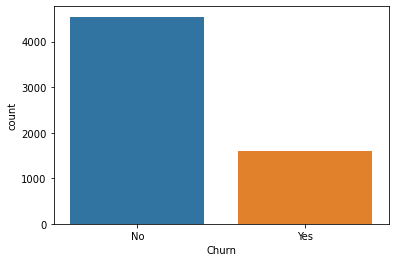

<Figure size 432x288 with 0 Axes>

In [11]:
sns.countplot(x='Churn',data=churn_df)
plt.show()
plt.savefig('count_plot')

In [12]:
count_no_sub = len(churn_df[churn_df['Churn']=="No"])
count_sub = len(churn_df[churn_df['Churn']=="Yes"])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("Porcentaje de no-cancelación", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("Porcentaje de cancelación", pct_of_sub*100)

Porcentaje de no-cancelación 74.00293016441478
Porcentaje de cancelación 25.99706983558522


Según los datos, de 6143 casos, hay 1597 (\~26%) de cancelaciones (Yes-churn) y 4596 (\~74%) de no cancelaciones (No-churn).

Esto da un punto de referencia. Un buen modelo de aprendizaje automático debería poder predecir con precisión la posible cancelación o no del servicio.

Antes de iniciar la implementación del modelo, es útil visualizar la distribución de algunas de las variables.

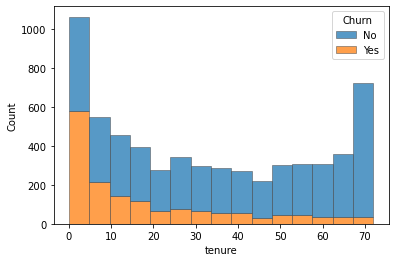

In [13]:
#Histogramas para variables númericas
sns.histplot(x="tenure", hue="Churn",data=churn_df,
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,);

**Figura 1.** Número de meses que el cliente ha permanecido en la empresa. Hay muchos clientes nuevos (menos de 10 meses) seguidos de un segmento de clientes fieles que permanece durante más de 70 meses en promedio. Son de interes los clientes que deciden no continuar con los servicios, con una tendencia a durar menos de 12 meses con la compañía. Es decir, un segmento a retener son los **nuevos clientes**.

También es de interés generar y fortalecer la estrategia de **fidelización** para los clientes leales.

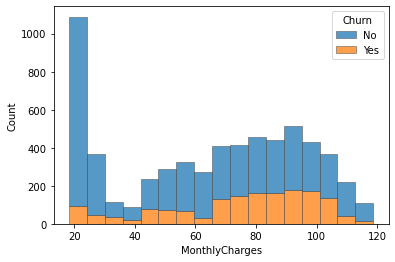

In [14]:
#Histogramas Cargos mensuales
sns.histplot(x="MonthlyCharges", hue="Churn",data=churn_df,
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,);

**Figura 2.** Monto cobrado al cliente mensualmente en USD. Se observa que para el rango del cargo mensual, entre mayor sea el cargo se tiene la cancelación del servicio.

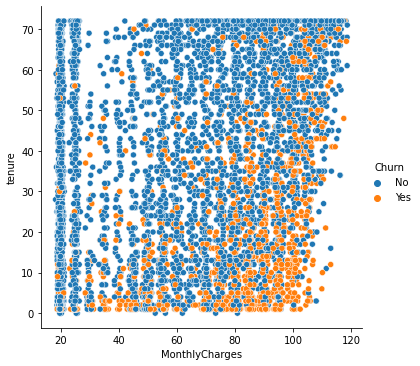

In [15]:
sns.relplot(x="MonthlyCharges", y="tenure",hue="Churn", data=churn_df);

**Figura 3.** Costos mensuales y su relación con el tiempo de permanencia. Empezando por estas dos variables, es interesante explorar si altos cargos asociados a cancelación se asocian a un tiempo menor de permanecia. Se observa que un grupo significativo de cliente que cancelan sus servicios recibierón altos cargos mensuales y permanecieron pocos meses con la compañía. Esto indica que la **oferta-valor** es relevante para la conservación de clientes.

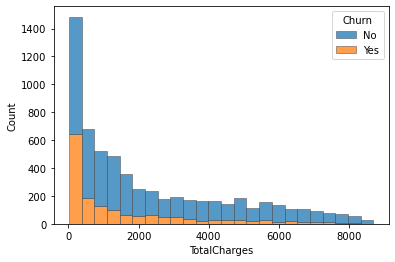

In [16]:
#Histogramas Cargos totales
sns.histplot(x="TotalCharges", hue="Churn",data=churn_df,
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,);

**Figura 4.** Monto total de por vida cobrado al cliente en USD.

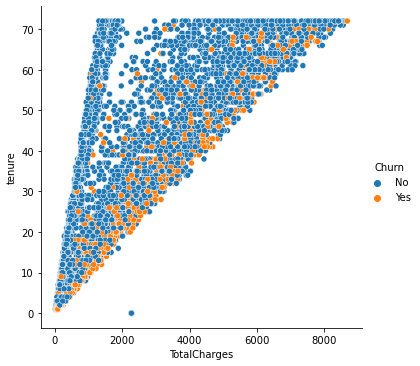

In [17]:
sns.relplot(x="TotalCharges", y="tenure",hue="Churn", data=churn_df);

**Figura 5.** Costos totales y su relación con el tiempo de permanencia.

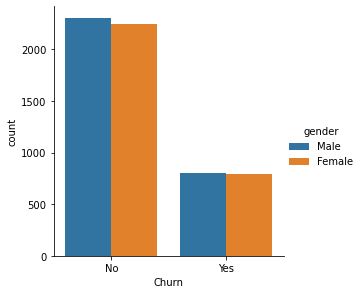

<Figure size 432x288 with 0 Axes>

In [18]:
#Visualización para variables categoricas
#Gender
sns.catplot(x='Churn', hue="gender",
            data=churn_df, kind="count",
            height=4);
plt.show()
plt.savefig('payment_plot')

**Figura 6.** La distribución por género muestra que el conjunto de datos presenta una proporción relativamente igual de clientes masculinos y femeninos. Casi la mitad de los clientes del conjunto de datos son mujeres, mientras que la otra mitad son hombres.

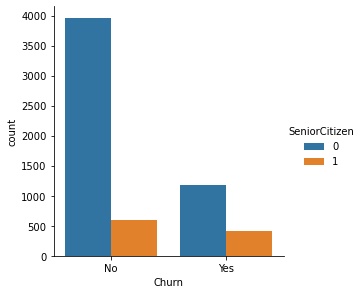

<Figure size 432x288 with 0 Axes>

In [19]:
#SeniorCitizen
sns.catplot(x='Churn', hue="SeniorCitizen",
            data=churn_df, kind="count",
            height=4);
plt.show()
plt.savefig('payment_plot')

**Figura 7.** La mayoría de los clientes son personas jóvenes. Los jóvenes son quienes más cancelan los servicios, por lo tanto se puede generar una estrategía de retención  enfocada en los más jóvenes.

<AxesSubplot:xlabel='SeniorCitizen', ylabel='MonthlyCharges'>

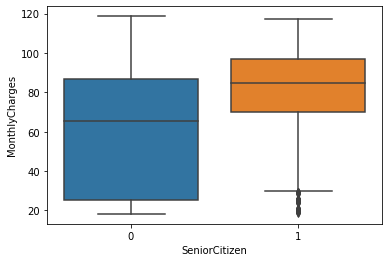

In [20]:
sns.boxplot(x="SeniorCitizen", y="MonthlyCharges", data=churn_df)

**Figura 8.** Monto mensual para jóvenes y seniors. Si bien los cargos para los jóvenes son más bajos, la razón de la cancelación podría estar asociada al **beneficio** obtenido de la oferta-valor.

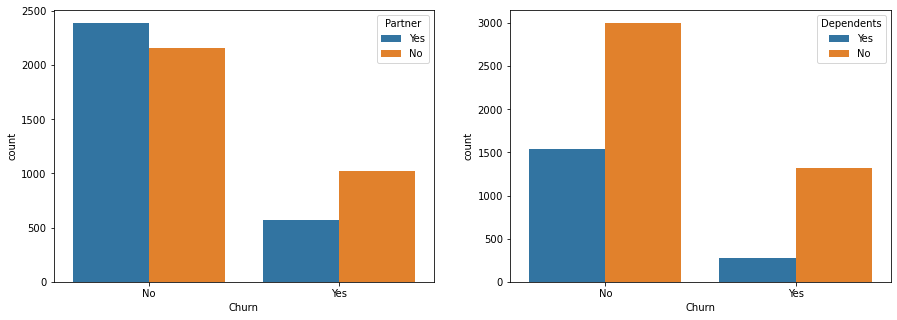

<Figure size 432x288 with 0 Axes>

In [21]:
#Partner&#Dependents
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(x='Churn', hue="Partner",
            data=churn_df,ax=axs[0]);

sns.countplot(x='Churn', hue="Dependents",
            data=churn_df,ax=axs[1]);

plt.show()
plt.savefig('partnerDependets_plot')

**Figura 9.** Histogramas para las variables *Partner* y *Dependents*. Se observa que de los clientes que cancelan los servicios la mayoría no reportan pareja ni personas a cargo. Es viable una estrategia de retención a este segmento de la población.

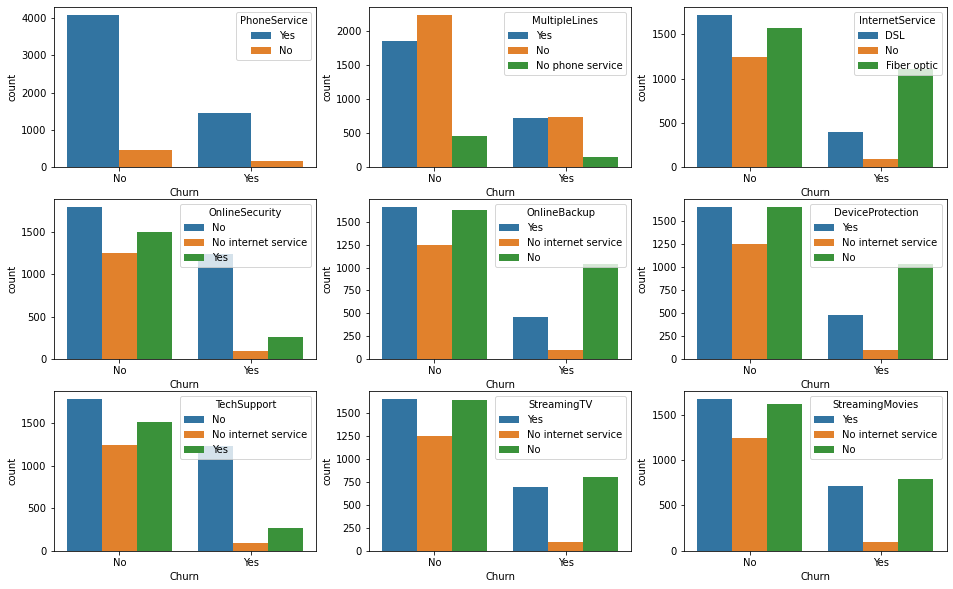

<Figure size 432x288 with 0 Axes>

In [22]:
#AllServices
fig, axs = plt.subplots(3, 3, figsize=(16, 10))

sns.countplot(x='Churn', hue="PhoneService",
            data=churn_df,ax=axs[0,0]);
sns.countplot(x='Churn', hue="MultipleLines",
            data=churn_df,ax=axs[0,1]);
sns.countplot(x='Churn', hue="InternetService",
            data=churn_df,ax=axs[0,2]);
sns.countplot(x='Churn', hue="OnlineSecurity",
            data=churn_df,ax=axs[1,0]);
sns.countplot(x='Churn', hue="OnlineBackup",
            data=churn_df,ax=axs[1,1]);
sns.countplot(x='Churn', hue="DeviceProtection",
            data=churn_df,ax=axs[1,2]);
sns.countplot(x='Churn', hue="TechSupport",
            data=churn_df,ax=axs[2,0]);
sns.countplot(x='Churn', hue="StreamingTV",
            data=churn_df,ax=axs[2,1]);
sns.countplot(x='Churn', hue="StreamingMovies",
            data=churn_df,ax=axs[2,2]);

plt.show()
plt.savefig('payment_plot')

**Figura 10.** Histogramas para los diferntes servicios.

Se observa que hay una tendencia a la cancelación de servicios asociada al servicio de internet de fibra óptica. Esto puede estar asociado con los cargos debidos a este tipo de servicio.

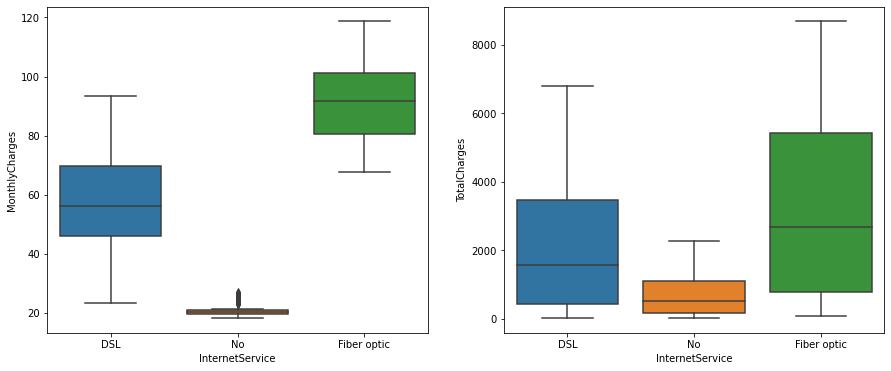

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
ax1=sns.boxplot(x="InternetService", y="MonthlyCharges",
                data=churn_df, ax=axs[0])
ax2=sns.boxplot(x="InternetService", y="TotalCharges",
                data=churn_df, ax=axs[1])
plt.show()

**Figura 11.** Distribución de montos mensuales (izquierda) y montos totales (derecha) para cada tipo de servicio de internet.

Se observa que los montos son mayores para el servicio de fibra óptica y esto, dependiendo de la oferta-valor, es un factor de cancelación de servicios. 

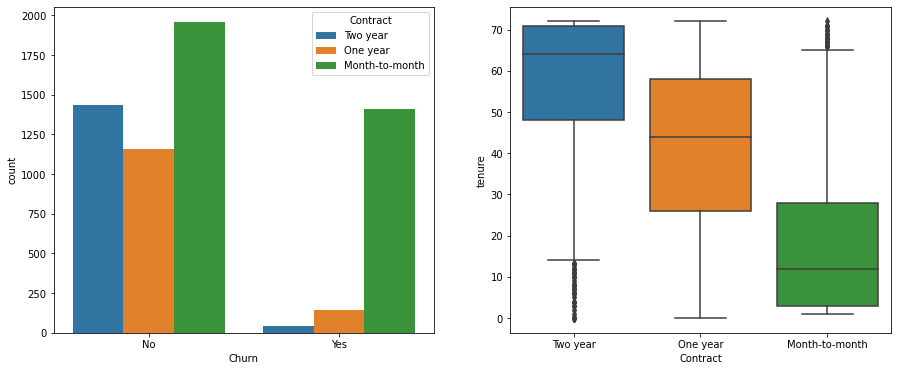

<Figure size 432x288 with 0 Axes>

In [24]:
#Contract
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
sns.countplot(x='Churn', hue="Contract",
            data=churn_df, ax=axs[0]);
sns.boxplot(x="Contract", y="tenure", data=churn_df,ax=axs[1])
plt.show()
plt.savefig('payment_plot')

**Figura 12.** Tipo de contrato. Se observa que los clientes que más cancelan el servicio tienen contratos cortos (Month-to-month). La distribución del tiempo de permanencia confirma que los clientes con contratos cortos no tienden a permanecer más de 30 meses y en promedio permanecen como clientes por 12 meses.

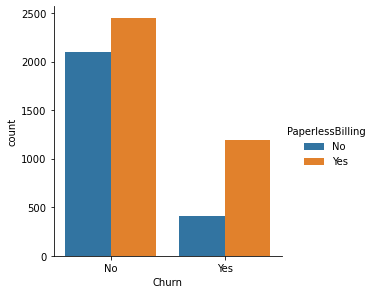

<Figure size 432x288 with 0 Axes>

In [25]:
#PaperlessBilling
sns.catplot(x='Churn', hue="PaperlessBilling",
            data=churn_df, kind="count",
            height=4);
plt.show()
plt.savefig('payment_plot')

**Figura 13.** Facturación electrónica. Se observa que la mayoría de los clientes que cancelan su servicio tienen facturación electrónica. Esto puede estar asociado con los montos y se revisa en las siguientes gráficas.

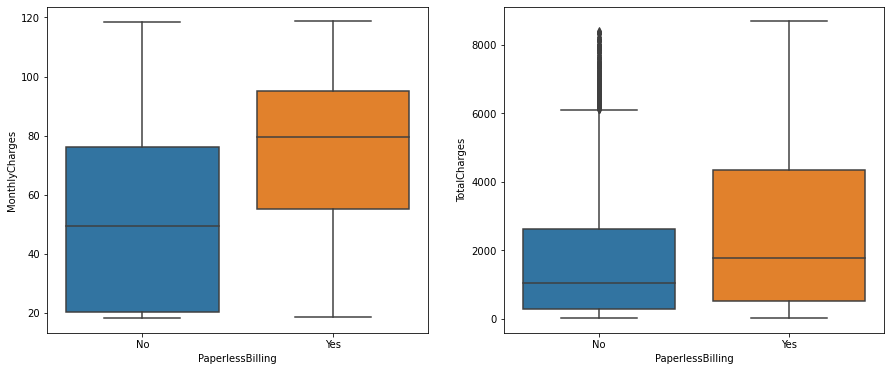

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
sns.boxplot(x="PaperlessBilling", y="MonthlyCharges",
                data=churn_df, ax=axs[0])
sns.boxplot(x="PaperlessBilling", y="TotalCharges",
                data=churn_df, ax=axs[1])
plt.show()

**Figura 14.** Facturación electrónica y su relación con los montos menusales (izquierda) y montos totales (derecha). Se observa que los cargos son más altos para los clientes con facturación electrónica.

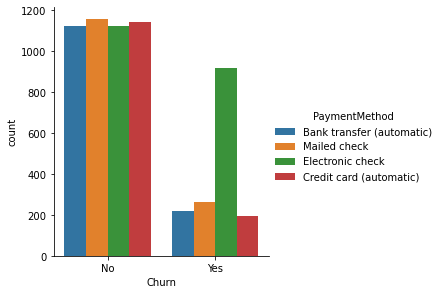

<Figure size 432x288 with 0 Axes>

In [27]:
#PaymentMethod
sns.catplot(x='Churn', hue="PaymentMethod",
            data=churn_df, kind="count",
            height=4);
plt.show()
plt.savefig('payment_plot')

**Figura 15.** Tipo de pago. Se observa que entre los clientes que cancelan el servicio, la mayoría paga de forma electrónica. 

Como se observo en la **Fig. 14** los cargos son mayores para las facturas electrónicas. En la siguiente gráfica se observa que la forma de pago no genera una diferencia considerable en los montos mensuales o totales.

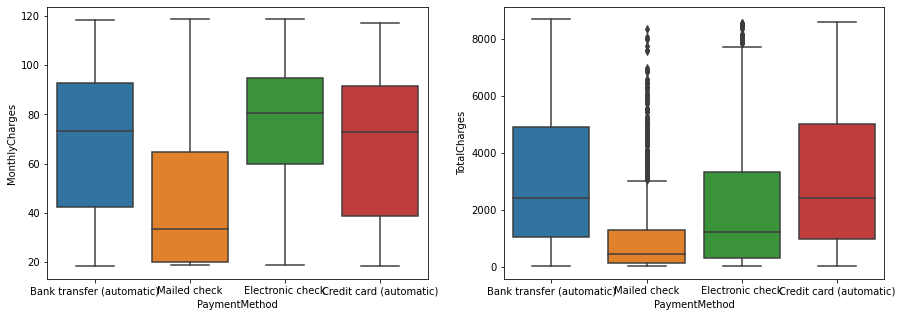

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x="PaymentMethod", y="MonthlyCharges",
                data=churn_df, ax=axs[0])
sns.boxplot(x="PaymentMethod", y="TotalCharges",
                data=churn_df, ax=axs[1])
plt.show()

## Desarrollo del modelo analítico

Para implmentar el modelo se van a realizar primero tres tareas:
 * Convertir los datos no numéricos en numéricos.
 * Dividir los datos en conjuntos de prueba y entrenamiento porque es necesario evaluar el modelo antes de hacer las predicciones.
 * Escalar los valores a un rango uniforme.

La conversión de los valores no numéricos en valores numéricos se hace porque no solo da como resultado un cálculo más rápido, sino que también muchos modelos de aprendizaje automático (como los desarrollados con scikit-learn) requieren que los datos estén en un formato estrictamente numérico. Esto se hace usando una técnica llamada *label encoding*.

In [29]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in churn_df.columns.to_numpy():
    if churn_df[col].dtypes == 'object':
        churn_df[col]=le.fit_transform(churn_df[col])

Se hace una visualización de la correlación del conjunto de datos.

In [30]:
churn_df.corr()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,1.000000,0.001548,0.012126,0.005278,0.000618,-0.007516,0.015722,0.005505,0.006983,-0.005445,...,-0.033037,-0.011625,-0.022039,-0.024898,-0.014395,-0.001622,0.022480,0.001918,-0.011038,0.010650
gender,0.001548,1.000000,0.004128,-0.002392,0.013789,-0.005380,0.000776,-0.006489,-0.001723,-0.021514,...,0.001253,-0.012462,-0.011052,-0.015254,-0.009188,-0.010421,0.018193,-0.014556,-0.007253,-0.002189
SeniorCitizen,0.012126,0.004128,1.000000,0.017530,-0.208232,0.015364,0.009157,0.141643,-0.034407,-0.124277,...,-0.025495,-0.154091,0.024673,0.045216,-0.145898,0.162929,-0.041462,0.217350,0.099030,0.151549
Partner,0.005278,-0.002392,0.017530,1.000000,0.448856,0.380337,0.020394,0.146485,0.000105,0.150831,...,0.161811,0.126599,0.132640,0.126130,0.294930,-0.012398,-0.159717,0.102254,0.321270,-0.146345
Dependents,0.000618,0.013789,-0.208232,0.448856,1.000000,0.156960,0.000278,-0.020555,0.047298,0.147091,...,0.078526,0.126901,0.042819,0.019771,0.241111,-0.115484,-0.035111,-0.114307,0.064179,-0.158547
tenure,-0.007516,-0.005380,0.015364,0.380337,0.156960,1.000000,0.013201,0.349649,-0.031700,0.324434,...,0.372327,0.320246,0.288424,0.294088,0.666252,0.016940,-0.370123,0.253725,0.825853,-0.344614
PhoneService,0.015722,0.000776,0.009157,0.020394,0.000278,0.013201,1.000000,-0.022881,0.391290,-0.009136,...,0.001953,-0.020050,0.062725,0.041550,0.004683,0.019068,-0.006175,0.247863,0.115949,0.009704
MultipleLines,0.005505,-0.006489,0.141643,0.146485,-0.020555,0.349649,-0.022881,1.000000,-0.108146,0.007792,...,0.122033,0.016138,0.177734,0.184146,0.114212,0.170266,-0.177300,0.433340,0.457361,0.035077
InternetService,0.006983,-0.001723,-0.034407,0.000105,0.047298,-0.031700,0.391290,-0.108146,1.000000,-0.024955,...,0.042409,-0.022490,0.109557,0.097046,0.101824,-0.142426,0.089684,-0.324433,-0.175134,-0.049309
OnlineSecurity,-0.005445,-0.021514,-0.124277,0.150831,0.147091,0.324434,-0.009136,0.007792,-0.024955,1.000000,...,0.174564,0.277957,0.044879,0.053897,0.368854,-0.146098,-0.088285,-0.050384,0.256051,-0.278593


Ahora, se dividen los datos en un conjunto de entrenamiento y un conjunto de pruebas para preparar los datos para dos fases diferentes del modelo de aprendizaje automático: entrenamiento y pruebas. Siguiendo la recomendación de no usar ninguna información de los datos de prueba para escalar los datos de entrenamiento, primero se dividen los datos y luego se hace el escalamiento.

In [31]:
from sklearn.model_selection import train_test_split

churn_df = churn_df.drop(['customerID'], axis=1)
churn_df_model = churn_df.to_numpy()

X,y = churn_df_model[:,0:19], churn_df_model[:,19]

X_train, X_test, y_train, y_test = train_test_split(X,
                                y,
                                test_size=0.33,
                                random_state=42)

Solo queda un paso final de preprocesamiento de escalado antes de poder ajustar un modelo de aprendizaje automático a los datos.

Se reescalan todos los valores númericos al rango de 0-1.

In [32]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.transform(X_test)

print ('Train set:', rescaledX_train.shape,  y_train.shape)
print ('Test set:', rescaledX_test.shape,  y_test.shape)

#rescaledX_test

Train set: (4115, 19) (4115,)
Test set: (2028, 19) (2028,)


Considerando que las variables están correlacionados, se usa el hecho de que los modelos lineales generalizados funcionan bien en estos casos. Se escoge entonces un **modelo de regresión logística**.

In [33]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(rescaledX_train,y_train)

LogisticRegression()

Finalmente se genera el conjunto de predicciones para el set de prueba y su respectiva porbabilidad.

In [34]:
y_pred = logreg.predict(rescaledX_test)
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [35]:
y_pred_prob = logreg.predict_proba(rescaledX_test)
y_pred_prob

array([[0.85275087, 0.14724913],
       [0.97826192, 0.02173808],
       [0.98338541, 0.01661459],
       ...,
       [0.57617106, 0.42382894],
       [0.9747571 , 0.0252429 ],
       [0.97349142, 0.02650858]])

## Evaluación del modelo analítico

Para evaluar el modelo se utilizan los resultados del conjunto de prueba `y_pred` y diferentes métricas.

### jaccard index

Se prueba el índice jaccard para evaluar la precisión. Se puede definir jaccard como el tamaño de la intersección dividido por el tamaño de la unión de dos conjuntos de etiquetas. Si todo el conjunto de etiquetas predichas para una muestra coincide estrictamente con el conjunto real de etiquetas, entonces la precisión del subconjunto es 1.0; de lo contrario, es 0.0.

In [36]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, y_pred,pos_label=0)

0.7678983833718245

### Confusion matrix

Otra forma de ver la precisión del clasificador es mirar la matriz de confusión.

In [37]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, y_pred, labels=[1,0]))

[[ 296  232]
 [ 170 1330]]


Confusion matrix, without normalization
[[ 296  232]
 [ 170 1330]]


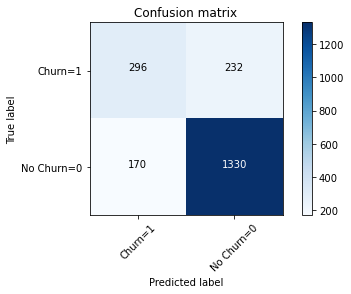

In [38]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[1,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Churn=1','No Churn=0'],normalize= False,  title='Confusion matrix')

La primera fila es para los clientes cuyo valor de cancelación en el conjunto de prueba es 1. Se observa que, de 2028 clientes, el valor de cancelación de 528 de ellos es 1. Y de estos 528, el clasificador predijo correctamente 296 de ellos como 1 y 232 de ellos como 0.

Significa que, para 296 clientes, el valor de cancelación real fue 1 en el conjunto de prueba, y el clasificador también predijo correctamente esos como 1. Sin embargo, mientras que la etiqueta real de 232 clientes fue 1, el clasificador predijo esos como 0, lo que no es bueno. Se puede considerar como un error del modelo de la primera fila.

Hubo 1500 clientes cuyo valor de abandono fue 0. El clasificador predijo correctamente 1330 de ellos como 0, y 170 de ellos incorrectamente como 1. Por lo tanto, ha hecho un buen trabajo al predecir los clientes con un valor de cancelación 0. La matriz de confusión muestra la capacidad del modelo para predecir correctamente o separar las clases. En un caso específico de clasificador binario se puede interpretar estos números como el recuento de verdaderos positivos, falsos positivos, verdaderos negativos y falsos negativos.

In [39]:
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87      1500
         1.0       0.64      0.56      0.60       528

    accuracy                           0.80      2028
   macro avg       0.74      0.72      0.73      2028
weighted avg       0.80      0.80      0.80      2028



  * La **precisión** es una medida de la precisión siempre que se haya predicho una etiqueta de clase. Está definido por: precisión = TP / (TP + FP)

  * **Recall** es la tasa de verdaderos positivos. Se define como: Recall = TP / (TP + FN)

Se puede calcular la precisión y el recall de cada clase.

**f1-score**: ahora estamos en condición de calcular f1-score para cada etiqueta en función de la precisión y el recall de esa etiqueta.

f1-score es el promedio armónico de la precisión y el recall, donde un f1-score alcanza su mejor valor en 1 (precisión y recall perfectas) y el peor en 0. Es una buena manera de demostrar que un clasificador tiene un buen valor para ambos recall y precisión.

Y finalmente, se puede decir que la precisión promedio para este clasificador es el promedio del f1-score para ambas etiquetas, que es 0.80 para el modelo implementado. 

### Curva ROC

La ***R**eceiver **O**perating **C**haracteristic* (ROC) es otra herramienta común utilizada con clasificadores binarios. La línea de puntos representa la curva ROC de un clasificador puramente aleatorio; un buen clasificador permanece lo más lejos posible de esa línea (hacia la esquina superior izquierda). 

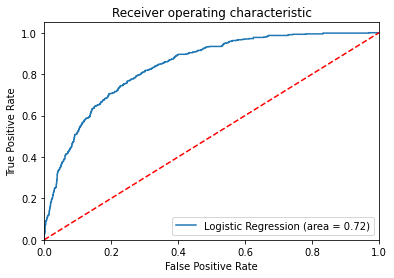

In [40]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(rescaledX_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(rescaledX_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Despliegue del modelo para usuarios actuales

El archivo *"Test sample No Label.xlsx”* es con el que se haran las predicciones para los usuarios actuales. Así como se hizo para el archivo csv, se debe revisar la calidad de los datos y prepararlos para usar el modelo desarrollado.

### Load Data From xlsx File

Se utiliza el método de Pandas `read_excel()` para cargar los datos desde el archivo suministrado a un DataFrame y visualizar la información que contiene.

In [41]:
churn_df_test = pd.read_excel("Test sample No Label.xlsx")
churn_df_test.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,8000,Male,0,Yes,Yes,5,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Bank transfer (automatic),25.90,135.00
1,8001,Female,0,Yes,Yes,30,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,100.05,3046.15
2,8002,Male,0,No,No,69,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),106.50,7348.80
3,8003,Female,0,Yes,No,69,Yes,No,DSL,No,Yes,No,No,No,Yes,Two year,Yes,Credit card (automatic),61.45,4131.20
4,8004,Male,0,No,No,50,Yes,Yes,DSL,No,No,Yes,Yes,No,Yes,Two year,No,Bank transfer (automatic),69.50,3418.20


In [42]:
churn_df_test_info = churn_df_test.info()
print(churn_df_test_info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        900 non-null    int64  
 1   gender            900 non-null    object 
 2   SeniorCitizen     900 non-null    int64  
 3   Partner           900 non-null    object 
 4   Dependents        900 non-null    object 
 5   tenure            900 non-null    int64  
 6   PhoneService      900 non-null    object 
 7   MultipleLines     900 non-null    object 
 8   InternetService   900 non-null    object 
 9   OnlineSecurity    900 non-null    object 
 10  OnlineBackup      900 non-null    object 
 11  DeviceProtection  900 non-null    object 
 12  TechSupport       900 non-null    object 
 13  StreamingTV       900 non-null    object 
 14  StreamingMovies   900 non-null    object 
 15  Contract          900 non-null    object 
 16  PaperlessBilling  900 non-null    object 
 1

La variable "*SeniorCitizen*" puede ser usada como variable categorica, tipo *object*, debe cambiarse de tipo para que sean de utilidad en el análisis.

In [43]:
churn_df_test['customerID'] = churn_df_test['customerID'].astype('object')
churn_df_test['SeniorCitizen'] = churn_df_test['SeniorCitizen'].astype('object')
print(churn_df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        900 non-null    object 
 1   gender            900 non-null    object 
 2   SeniorCitizen     900 non-null    object 
 3   Partner           900 non-null    object 
 4   Dependents        900 non-null    object 
 5   tenure            900 non-null    int64  
 6   PhoneService      900 non-null    object 
 7   MultipleLines     900 non-null    object 
 8   InternetService   900 non-null    object 
 9   OnlineSecurity    900 non-null    object 
 10  OnlineBackup      900 non-null    object 
 11  DeviceProtection  900 non-null    object 
 12  TechSupport       900 non-null    object 
 13  StreamingTV       900 non-null    object 
 14  StreamingMovies   900 non-null    object 
 15  Contract          900 non-null    object 
 16  PaperlessBilling  900 non-null    object 
 1

Con base en la información anterior se sabe que cada columna tiene 900 filas de datos y que en ninguna columna se presentan datos faltantes.

### Data exploration

Utilizando el método `.describe()` se obtiene información estadística de los datos, tanto de las variables categoricas como de las númericas.

**Variables categóricas**

In [44]:
churn_df_test_description_categ = churn_df_test.describe(include=['object'])
print(churn_df_test_description_categ)

        customerID gender  SeniorCitizen Partner Dependents PhoneService  \
count          900    900            900     900        900          900   
unique         900      2              2       2          2            2   
top           8000   Male              0      No         No          Yes   
freq             1    451            762     460        614          825   

       MultipleLines InternetService OnlineSecurity OnlineBackup  \
count            900             900            900          900   
unique             3               3              3            3   
top               No     Fiber optic             No           No   
freq             421             413            464          412   

       DeviceProtection TechSupport StreamingTV StreamingMovies  \
count               900         900         900             900   
unique                3           3           3               3   
top                  No          No          No              No   
freq      

#### Variables númericas

In [45]:
churn_df_test_description_values = churn_df_test.describe()
print(churn_df_test_description_values)

           tenure  MonthlyCharges  TotalCharges
count  900.000000      900.000000    900.000000
mean    33.310000       65.940833   2353.882222
std     25.237217       29.495604   2296.744079
min      1.000000       18.850000     18.850000
25%      8.000000       43.975000    374.837500
50%     31.000000       72.975000   1434.350000
75%     57.250000       89.812500   3887.600000
max     72.000000      118.750000   8672.450000


Para implmentar el modelo se van a realizar primero dos tareas:
 * Convertir los datos no numéricos en numéricos.
 * Escalar los valores a un rango uniforme.

La conversión de los valores no numéricos se hace usando una técnica llamada *label encoding*.

In [46]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in churn_df_test.columns.to_numpy():
    if churn_df_test[col].dtypes == 'object':
        churn_df_test[col]=le.fit_transform(churn_df_test[col])

Solo queda un paso final de preprocesamiento de escalado antes de poder utilizar un modelo de aprendizaje automático a los datos.

Se reescalan todos los valores númericos al rango de 0-1.

In [47]:
from sklearn.preprocessing import MinMaxScaler

churn_df_test = churn_df_test.drop(['customerID'], axis=1)
churn_df_test_model = churn_df_test.to_numpy()

scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX_pred = scaler.fit_transform(churn_df_test_model)

print ('Usuarios actuales set:', rescaledX_pred.shape)

Usuarios actuales set: (900, 19)


In [48]:
churn_pred = logreg.predict(rescaledX_pred)
churn_pred

array([0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 0.

In [49]:
churn_pred_prob = logreg.predict_proba(rescaledX_pred)
churn_pred_prob

array([[0.79, 0.21],
       [0.41, 0.59],
       [0.93, 0.07],
       ...,
       [0.99, 0.01],
       [0.89, 0.11],
       [0.98, 0.02]])

In [50]:
churn_pred_df = pd.DataFrame(data=churn_pred, columns=["Churn"])
churn_pred_df['Churn'].replace(to_replace=[0,1], value=['No','Yes'],inplace=True)
churn_pred_df

,Churn
0,No
1,Yes
2,No
3,No
4,No
...,...
895,Yes
896,Yes
897,No
898,No


Se van a incluir los valores predecidos al archivo original.

In [51]:
churn_df_test["Churn"] = churn_pred_df
churn_df_test
churn_df_test.to_excel("TestSampleLabeled.xlsx")

In [52]:
churn_pred_df['Churn'].value_counts()

No     689
Yes    211
Name: Churn, dtype: int64

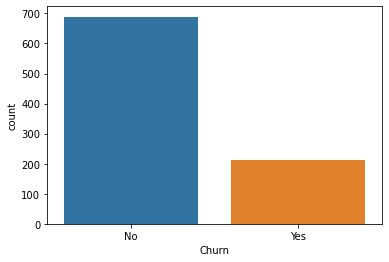

<Figure size 432x288 with 0 Axes>

In [53]:
sns.countplot(x='Churn',data=churn_pred_df)
plt.show()
plt.savefig('count_pred_plot')

In [54]:
count_no_sub = len(churn_pred_df[churn_pred_df['Churn']=="No"])
count_sub = len(churn_pred_df[churn_pred_df['Churn']=="Yes"])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("Porcentaje de no-cancelación", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("Porcentaje de cancelación", pct_of_sub*100)

Porcentaje de no-cancelación 76.55555555555556
Porcentaje de cancelación 23.444444444444446


Según los datos, de 900 casos, hay 211 (23.4%) de cancelaciones (churn) y 689 (76.5%) de no cancelaciones (no-churn).

El modelo de aprendizaje automático predece con precisión la posible cancelación o no del servicio.

## Estrategia de retención de clientes

 * El modelo informa con una precisión la cantidad de clientes que podrían cancelar el servicio con la compañía.
 
 
 * Para retener a los clientes la estrategia debe tener las siguientes caracteristicas:
   * Buscar la **conservación a largo plazo de los clientes**.
   * Basarse en el servicio con acciones en las áreas de:
       * Atención al cliente (canales de voz y presencial).
       * PQR
       * Información de ofertas.
 
 
 * La estrategia de retención de clientes debe tener un enfoque especifico por segmentos de población.
   * Enfocar estrategias de mercadeo y fidelización hacia el segmento de clientes con baja probabilidad de cancelar el servicio, cerca del 76.5%, y con permanencia mayor a 12 meses  teniendo en cuenta el monto del servicio que le es facturado, es decir, usar el acompañamiento para mejorar la experiencia costo-beneficio.
   * Para el segmento con mayor probabilidad de cancelar el servicio, cerca del 23.4%, se sugiere implementar:
      * El segmento de **nuevos clientes** debe tener un acompañamiento que permita el *feedback* de la oferta-valor en sus primeros meses de contrato.
      * Debe revisarse de forma constante la oferta-valor, sobre todo para los contratos en modalidad mes a mes, promoviendo contratos de mayor duración.
      * Promover una oferta diferenciada para jóvenes y solteros, enfocada en los servicios que estos segmentos reportan como de mayor demanda.
      * Revisar la política de montos respecto a la facturación electrónica.
      * Revisar el desempeño técnico de la tecnología de fibra óptica para garantizar un costo-beneficio atractivo para los usuarios de esta.